In [1]:
import os
from itertools import chain, compress
import random
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from settings import EEGSettings
import eeg_lib
import importlib
importlib.reload(eeg_lib)
from eeg_lib import  create_dataset, load_data, predict_lm, predict_lgbm, plot_patterns, plot_clusters, plot_roc_curves, plot_feature_importance

In [3]:
###

path = '/Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)'
chan_drop = ['E8','E14','E21','E25','E43','E48','E49','E56','E57','E63','E64','E65','E68','E69','E73','E74','E81'
             ,'E82','E88','E89','E90','E94','E95','E99','E100','E107','E113','E119','E120','E125','E126','E127'
             ,'E128']
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
events_list = [241,242,244]
fr_bands = {   "theta1":  [4,6],
               "theta2":  [6,8],
               "alpha1": [8,10],
               "alpha2": [10,12],
               "beta1":  [12,16],
               "beta2":  [16,20],
               "beta3":  [20,24]}
dict_cls = { "241/244": [0,2],
             "242/244": [1,2],
             "241/242": [0,1] }
files = [f for f in sorted(os.listdir(path))]
_ = files.pop(0)
indexes = []
for i,j in enumerate(files):
    indexes.append(re.search('(.+?)_', j).group(1))

mat = ['311','312','314','315','316','317','326','327','328','330','334','335']
not_mat = [x for x in indexes if x not in mat]
index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]
subj_list_table, subj_list_features, e_list = [], [], []

In [5]:
def eeg_power_band(epochs_list):
    fin_table, fin_feat = [], []
    for beta in range(len(epochs_list)):
        psds, freqs = psd_multitaper(epochs_list[beta])
        psds_table = np.mean(psds, axis=0)
        psds /= psds.sum(axis=-1)[..., None]
        psds_table /= psds_table.sum(axis=-1)[..., None]
        psd_table_list, psd_features_list = [], []
        for fmin, fmax in fr_bands.values():
            freq_mask = (fmin < freqs) & (freqs < fmax)
            data_table, data_feat = psds_table[..., freq_mask].mean(axis=-1), psds[..., freq_mask].mean(axis=-1)
            psd_features_list.append(data_feat)
            psd_table_list.append(data_table)
        fin_table.append(psd_table_list)
        fin_feat.append(psd_features_list)
    return fin_feat, fin_table

In [6]:
path = '/Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)'

subj_list_table, subj_list_features, e_list = [], [], []
for file_name in files:
    paths = glob.glob(path + '/{0}/*.edf'.format(file_name))
    epochs_list = []
    j = 0
    for i in paths:
        event_id = dict(a='0')
        raw = mne.io.read_raw_edf(i)
        if 'Markers' in raw.ch_names:
           raw.drop_channels(['Markers'])
        else:
           raw.drop_channels(['Status'])
        if  len(raw.times)//250 < 10:
            continue
        new_events = mne.make_fixed_length_events(raw, id=0, start=0, duration=2, overlap=0)
        if j==1:
            epochs = mne.concatenate_epochs([mne.Epochs(raw, new_events, event_id = 0, tmin=0,
                                                        tmax=2, baseline=None, flat=dict(eeg=1e-20),
                                                        preload=True), epochs])
        else:
            epochs = mne.Epochs(raw, new_events, event_id = 0 , tmin=0, tmax=2, baseline=None,
                                flat=dict(eeg=1e-20), preload=True)
            j+=1
    epochs_list.append(epochs.copy())
    for teta in range(len(epochs_list)):
            new_names = {}
            new_names = dict(
                    (ch_name,
                     ch_name.replace('-', '').replace('Chan ', 'E').replace('CAR', '').replace('EEG ', '')
                     .replace('CA', '').replace(' ', ''))
                     for ch_name in epochs_list[teta].ch_names)
            epochs_list[teta].rename_channels(new_names).set_montage(montage).drop_channels(chan_drop)
    e_list.append(epochs_list)
    feat_list, tabl_list = eeg_power_band(epochs_list)
    subj_list_table.append(tabl_list)
    subj_list_features.append(feat_list)
chan1 = epochs_list[0].ch_names

Extracting EDF parameters from /Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)/311_Math_rest_open/311_Math_rest_open_n_7_m_212_t_215_eda_0_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 1001 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)/311_Math_rest_open/311_Math_rest_open_n_14_m_212_t_215_eda_0_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 1001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
14 ma

In [ ]:
l_lens = np.zeros((26,1))

for i in range(len(indexes)):
      l_lens[i] = len(e_list[i][0])
e_list[0]

df_subj = pd.DataFrame(l_lens, columns=['epochs'], index=indexes)
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads', 'subjects_epochs_128.xlsx'))
df_subj.to_excel(writer)
writer.save()

In [8]:
from sklearn.metrics import balanced_accuracy_score

In [40]:
from sklearn.metrics import roc_curve
from sklearn import metrics

In [199]:
list_A, list_B = [], []
#index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]
#new_mat = ['314', '326', '327', '328', '335', '315']
#new_not_mat = ['318','319','320','322','333','329']
#new_mat = ['311', '312', '316', '317', '330', '334']
#new_not_mat = ['313','324','331','332','337','336']
#new_mat = ['326', '330', '316', '328', '314', '335', '327', '312', '317', '334']
#new_not_mat = ['333', '320', '319', '336', '331', '323', '313', '324', '325', '337']
new_mat = ['311', '316', '312', '334', '313', '332', '324', '337']
new_not_mat = ['314','327','326','335','329','319', '318', '320']

index_mat, index_not_mat = [indexes.index(i) for i in new_mat], [indexes.index(i) for i in new_not_mat]
all_indexes = index_mat + index_not_mat
coefs_group = np.zeros((4,10,2,len(fr_bands),len(chan1)))
results_group = np.zeros((10,2))
#all_indexes_table = mat + not_mat
#all_indexes = np.array(all_indexes)
index_mat, index_not_mat = np.array(index_mat), np.array(index_not_mat)
ind = 0
im1 = []
tprs = []
aucs = []
fprl = []
tprl = []
for count, (s_ind_1, s_ind_2) in enumerate(zip(index_mat, index_not_mat)):
    mean_fpr = np.linspace(0, 1, 100)
    A =  np.concatenate(([np.stack([subj_list_features[j] for j in index_mat[index_mat!=s_ind_1]][i][ind],axis = 1)
                      for i in range(index_mat[index_mat!=s_ind_1].shape[0])]),axis=0)
    B =  np.concatenate(([np.stack([subj_list_features[j] for j in index_not_mat[index_not_mat!=s_ind_2]][i][ind],axis = 1)
                      for i in range(index_not_mat[index_not_mat!=s_ind_2].shape[0])]),axis=0)
    C1 = np.stack(subj_list_features[s_ind_1][ind], axis = 1)
    C2 = np.stack(subj_list_features[s_ind_2][ind], axis = 1)
    x_train = np.concatenate((A,B),axis=0)
    y_train = [0]*A.shape[0] + [1]*B.shape[0]
    x_test = np.concatenate((C1, C2),axis=0)
    y_test = [0]*C1.shape[0] + [1]*C2.shape[0]
    x_train = x_train.reshape(x_train.shape[0],-1)
    x_test = x_test.reshape(x_test.shape[0],-1)
    # test size 0.2
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.1)
    sc = StandardScaler()
    sc.fit(x_train)
    x_train = sc.transform(x_train)
    x_test = sc.transform(x_test)
    lgb = LGBMClassifier(objective='binary')
    lgb.fit(x_train, y_train)
    feature_importances = (lgb.feature_importances_ / sum(lgb.feature_importances_)) * 100
    im1.append(feature_importances)
    predictions = lgb.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, predictions[:,0], pos_label=0)
    fprl.append(predictions)
    tprl.append(y_test)
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    auc = roc_auc_score(y_test, predictions[:,1])
    ac = balanced_accuracy_score(y_test, lgb.predict(x_test))
    results_group[count, 0] = ac
    results_group[count, 1] = auc

In [207]:
results_group = pd.DataFrame(results_group, columns = ['accuracy', 'auc'] )

In [42]:
results_group

array([[0.5       , 0.46474454],
       [0.92176871, 0.98804665],
       [0.8577381 , 0.92342687],
       [0.94993165, 0.99209062],
       [0.5       , 0.7160256 ],
       [0.4962406 , 0.31704261],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [200]:
def plot_topo(ar, info):
    #vmin = np.amin(ar)
    vmin = 0
    vmax = np.amax(ar)
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30, 20))
    ss = 0
    for i, key in enumerate(list(fr_bands.keys())):
        if i in range(7):
            evoked = mne.EvokedArray(ar[i,:].reshape(-1,1),
                             info, tmin=0.)
            a = evoked.plot_topomap(axes=axes[ss], time_format=None, colorbar = False,  times=[0], cmap='hot',
                                    size = 5, show_names = False, vmin = 0, show = False)
            axes[ss].set_title(label = '{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
            ss+=1
    m = cm.ScalarMappable(cmap='hot')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    plt.figtext(0.5, 0.7, '{}'.format('Features importance'), va="center", ha="center", size=60, fontweight = 'semibold')
    return fig

In [43]:
from itertools import compress

In [201]:
a_l = list(compress(im1, results_group [:,1]>0.5))
fin_ar = np.mean(a_l, axis=0).reshape((7,95))

In [202]:
info = epochs_list[0].info
info1 = mne.create_info(info.ch_names, ch_types= 'eeg',
                        sfreq = 250)
info1.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E9, E10, E11, E12, E13, E15, E16, ...
 chs: 95 EEG
 custom_ref_applied: False
 dig: 98 items (3 Cardinal, 95 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 95
 projs: []
 sfreq: 250.0 Hz
>

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

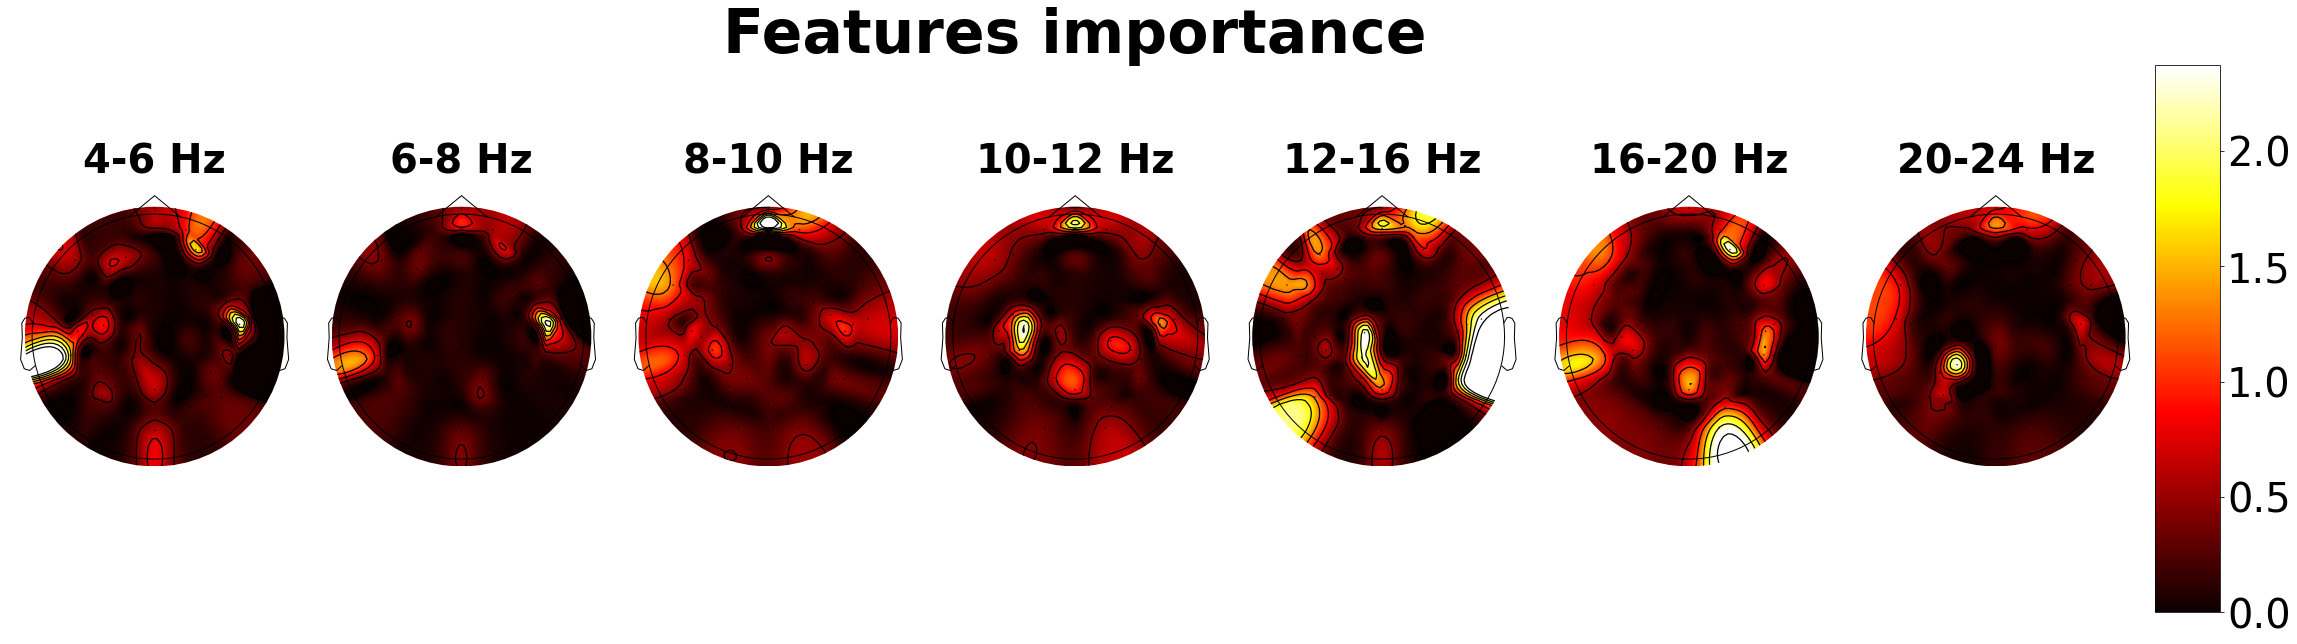

In [203]:
from matplotlib import cm
fig = plot_topo(fin_ar, info1)

In [204]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_imp_resting_suc_not_suc.png'), format='png',
            bbox_inches='tight', dpi=600)
#plt.save(os.path.join(path_subj_topo, 'cluster_test_244_fin_3.png'), format='png', dpi=600)
plt.close(fig)

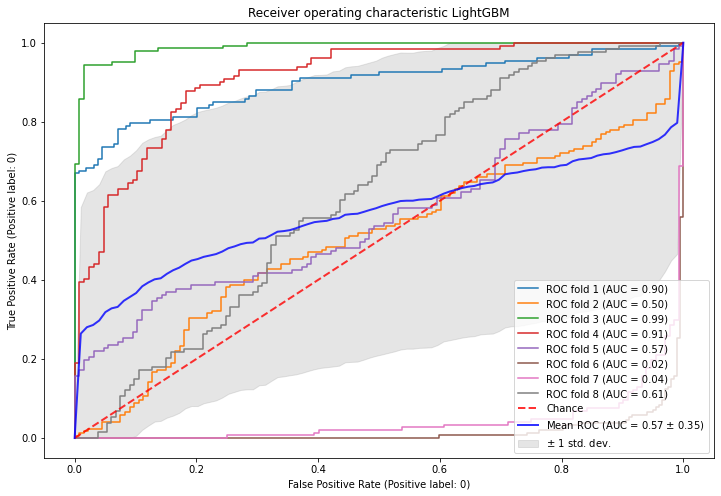

In [205]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves

fig, ax = plt.subplots(figsize=(12, 8))
for i, (tpr, fpr) in enumerate(zip(tprl, fprl)):
    viz = RocCurveDisplay.from_predictions(
        y_true=tpr,
        y_pred=fpr[:,0].tolist(),
        name=f"ROC fold {i+1}",
        pos_label = 0,
        ax=ax
    )
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic LightGBM",
)
ax.legend(loc="lower right")
plt.show()

In [206]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'lgb_roc_auc_resting_suc_not_suc.png'), format='png', bbox_inches='tight', dpi=600)

In [208]:
results_group.to_csv(os.path.join('/Users/ilyamikheev/Downloads/', 'res_lgb_suc_not_suc.csv'))

In [ ]:
# 19 channels
# delete FP1, FP2
path = '/Users/ilyamikheev/Downloads/19_CHANNEL_split_REST_open_for_Ilia'
files = [f for f in sorted(os.listdir(path))]
_ = files.pop(0)
indexes = []
for i,j in enumerate(files):
    indexes.append(re.search('(.+?)_', j).group(1))
chan_drop = ['O1', 'O2']
montage = mne.channels.make_standard_montage('standard_1020')
fr_bands = {   "theta1":  [4,6],
               "theta2":  [6,8],
               "alpha1": [8,10],
               "alpha2": [10,12],
               "beta1":  [12,16],
               "beta2":  [16,20],
               "beta3":  [20,24] }
mat = ['004','008','009','011','012','013','015','016']
not_mat = [x for x in indexes if x not in mat]
index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]

In [69]:
def predict(x_train, x_test, y_train, y_test):
    results = np.zeros((1,4))
    model = make_pipeline( StandardScaler(),
                               LinearModel(LogisticRegressionCV(
                               Cs=list(np.power(10.0, np.arange(-10, 10))),
                               penalty='l2',
                               scoring='roc_auc',
                               random_state=0,
                               max_iter=10000,
                               fit_intercept=True,
                               solver='newton-cg',
                               class_weight='balanced',
                               tol=10
                                                                       )))
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    ac =  balanced_accuracy_score(y_test,y_predict)
    score = model.score(x_test,y_test)
    #cm=confusion_matrix(y_test,y_predict)
    #TN,TP,FN,FP = cm[1,1],cm[0,0],cm[1,0],cm[0,1]
    #results[0,0], results[0,1] = accuracy_score(y_test,y_predict), 0
    #results[0,2], results[0,3] = TP/float(TP+FN), TN/float(TN+FP)

    return ac, score, model, predictions
# plot topomap for each freq band

In [189]:
list_A, list_B = [], []
#index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]
#new_mat = ['314', '326', '327', '328', '335', '315']
#new_not_mat = ['318','319','320','322','333','329']
new_mat = ['311', '316', '312', '334', '313', '332', '324', '337']
new_not_mat = ['314','327','326','335','329','319', '318', '320']
#new_mat = ['311', '312', '316', '317', '330', '334']
#new_not_mat = ['313','324','331','332','337','336']
#new_mat = ['326', '330', '316', '328', '314', '335', '327', '312', '317', '334']
#new_not_mat = ['333', '320', '319', '336', '331', '323', '313', '324', '325', '337']
index_mat, index_not_mat = [indexes.index(i) for i in new_mat], [indexes.index(i) for i in new_not_mat]
all_indexes = index_mat + index_not_mat
coefs_group = np.zeros((10,2,len(fr_bands),len(chan1)))
results_group_l = np.zeros((10,2))
#all_indexes_table = mat + not_mat
#all_indexes = np.array(all_indexes)
index_mat, index_not_mat = np.array(index_mat), np.array(index_not_mat)
tprs = []
aucs = []
fprl = []
tprl = []
for count, (s_ind_1, s_ind_2) in enumerate(zip(index_mat, index_not_mat)):
    mean_fpr = np.linspace(0, 1, 100)
    A =  np.concatenate(([np.stack([subj_list_features[j] for j in index_mat[index_mat!=s_ind_1]][i][ind],axis = 1)
                      for i in range(index_mat[index_mat!=s_ind_1].shape[0])]),axis=0)
    B =  np.concatenate(([np.stack([subj_list_features[j] for j in index_not_mat[index_not_mat!=s_ind_2]][i][ind],axis = 1)
                      for i in range(index_not_mat[index_not_mat!=s_ind_2].shape[0])]),axis=0)
    C1 = np.stack(subj_list_features[s_ind_1][ind], axis = 1)
    C2 = np.stack(subj_list_features[s_ind_2][ind], axis = 1)
    x_train = np.concatenate((A,B),axis=0)
    y_train = [0]*A.shape[0] + [1]*B.shape[0]
    x_test = np.concatenate((C1, C2),axis=0)
    y_test = [0]*C1.shape[0] + [1]*C2.shape[0]
    x_train = x_train.reshape(x_train.shape[0],-1)
    x_test = x_test.reshape(x_test.shape[0],-1)
    # test size 0.2
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.1)
    ac, auc, model, predictions = predict(x_train, x_test, y_train, y_test)
    fpr, tpr, _ = roc_curve(y_test, predictions[:,0], pos_label=0)
    fprl.append(predictions)
    tprl.append(y_test)
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    for name, i in zip(['patterns_', 'filters_'],[0,1]):
        coef = get_coef(model, name, inverse_transform=True)
        coefs_group[count,i,...] = coef.reshape(len(fr_bands),-1)
    results_group_l[count, 0] = ac
    results_group_l[count, 1] = auc

In [190]:

from sklearn.preprocessing import minmax_scale

In [191]:
a_lf = []
a_l = coefs_group[results_group_l[:, 1] > 0.5, ...]
s = a_l[0].shape
for i in range(len(a_l)):
    k = minmax_scale(a_l[i].reshape(2, -1), feature_range=(-1, 1), axis=1)
    a_lf.append(k.reshape(s))
fin_ar = np.mean(a_lf, axis=0)

In [192]:
def plot_patterns(ar):
    #vmin = - np.amax(ar)
    #vmax = np.amax(ar)
    vmax = 1
    vmin = -1
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(30, 20))
    for name, pos, plot_name, ind in zip(('patterns_', 'filters_'),(0.82,0.5),
                                         ('Patterns','Filters'),(0,1)):
        for i,key in enumerate(list(fr_bands.keys())):
            a = mne.viz.plot_topomap(ar[ind,i,:],info,vmin=vmin,vmax=vmax, axes=axes[ind,i],
                                 show = False)
            axes[ind,i].set_title(label='{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
        plt.figtext(0.5,pos,'{}'.format(plot_name), va="center", ha="center", size=44, fontweight = 'semibold')
    m = cm.ScalarMappable(cmap='RdBu_r')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    return fig

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

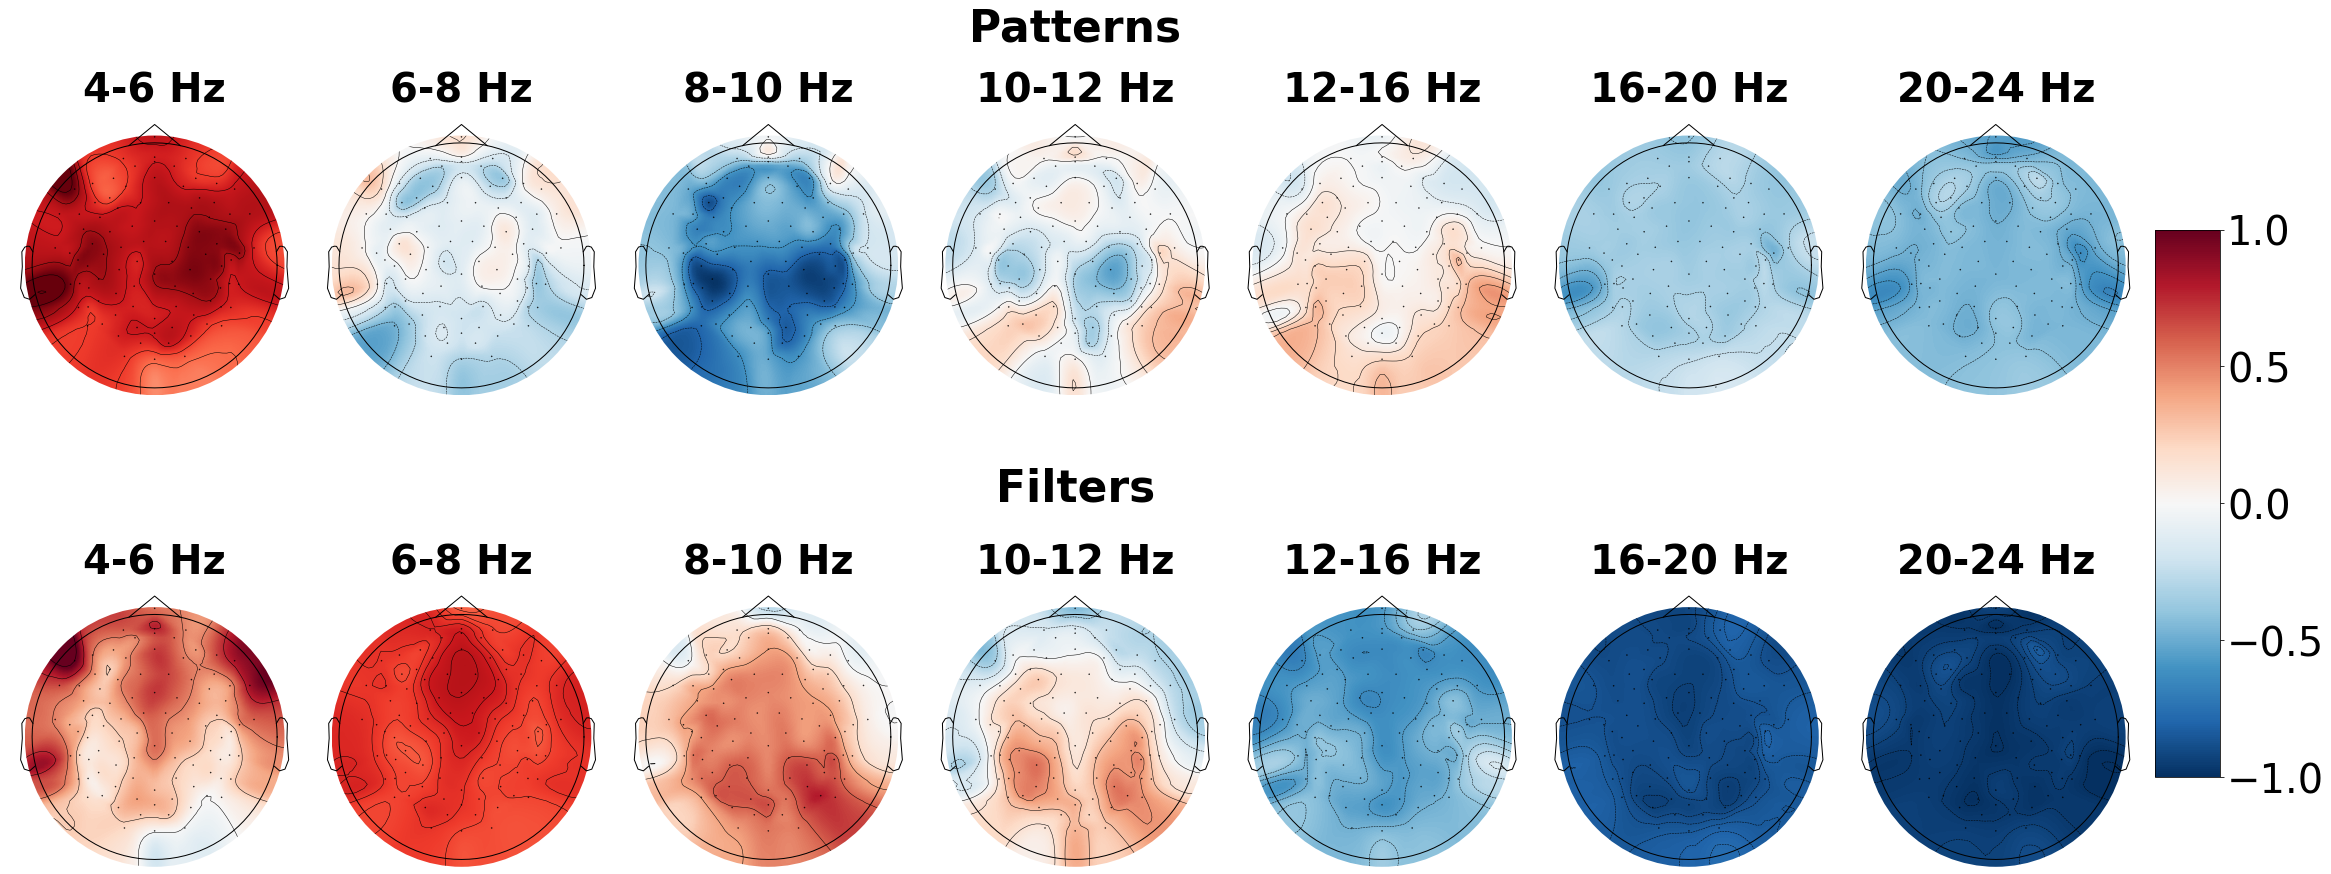

In [193]:
fig = plot_patterns(fin_ar)

In [194]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_patterns_resting_suc_not_suc.png'), format='png', bbox_inches='tight', dpi=600)

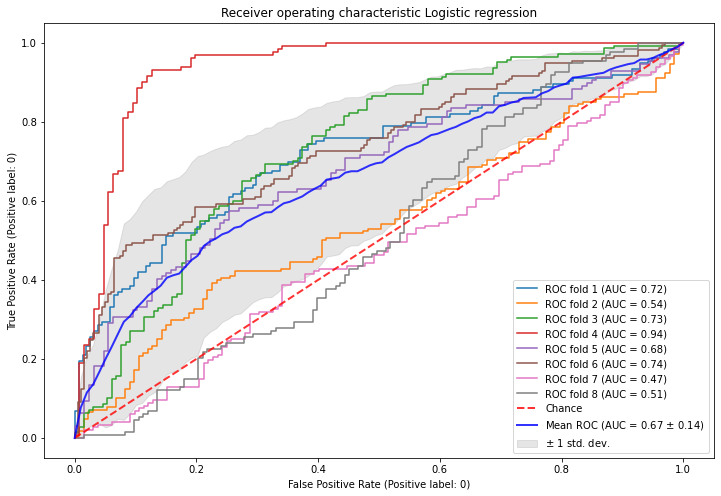

In [195]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves

fig, ax = plt.subplots(figsize=(12, 8))
for i, (tpr, fpr) in enumerate(zip(tprl, fprl)):
    viz = RocCurveDisplay.from_predictions(
        y_true=tpr,
        y_pred=fpr[:,0].tolist(),
        name=f"ROC fold {i+1}",
        pos_label = 0,
        ax=ax
    )
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic Logistic regression",
)
ax.legend(loc="lower right")
plt.show()

In [196]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'linear_roc_auc_resting_suc_not_suc.png'), format='png', bbox_inches='tight', dpi=600)

In [197]:
results_group = pd.DataFrame(results_group_l, columns = ['accuracy', 'auc'] )

In [198]:
results_group.to_csv(os.path.join('/Users/ilyamikheev/Downloads/', 'res_suc_not_suc_lin.csv'))

In [111]:
len(subj_list_table[0][0])

7

In [113]:
subj_list_table[0][0][0].shape

(95,)

In [120]:
from mne.stats import permutation_cluster_test

In [130]:
new_mat = ['311', '312', '316', '317', '330', '334']
new_not_mat = ['313','324','331','332','337','336']

In [177]:
a1 = np.stack(subj_list_table)
res_ar = np.zeros_like(a1[0,0,...])
a2 = a1[:,0,...]
ll = []
for i in range(7):
    a3 = a2[:,i,:]
    b1 = a3[index_mat]
    b2 = a3[index_not_mat]
    T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
                             n_permutations=1000)
    T_obs_plot = np.nan * np.ones_like(T_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            T_obs_plot[c] = T_obs[c]
    np.nan_to_num(T_obs_plot, copy=False)
    if np.count_nonzero(T_obs_plot) > 0:
        ll.append(i)
        res_ar[i,:] = T_obs_plot
mr_ar = res_ar>0

stat_fun(H1): min=0.000367 max=1.386138
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000044 max=1.651138
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.046010 max=6.155287
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.021324 max=4.851207
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000000 max=3.909156
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000000 max=0.847904
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000002 max=0.811219
Running initial clustering
Found 0 clusters


/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10:

In [178]:
 b1

array([[2.65854103e-04, 1.67644844e-04, 1.26386864e-04, 1.14572880e-04,
        3.02105097e-04, 2.55256871e-04, 1.33120934e-04, 1.89275945e-04,
        1.70499265e-04, 1.76113712e-04, 3.24621237e-04, 2.38863538e-04,
        2.51798270e-04, 1.52603470e-04, 5.11836754e-04, 1.57124577e-04,
        2.36255566e-04, 4.37861291e-04, 2.11479576e-04, 9.63035860e-05,
        3.50206962e-04, 1.09067428e-04, 2.22968885e-04, 4.12409695e-04,
        2.21427309e-04, 4.08015203e-04, 8.27648755e-04, 3.43895911e-04,
        2.74888315e-04, 2.20404294e-04, 4.24026100e-04, 3.05229788e-04,
        6.29461916e-04, 2.29967085e-04, 2.38595334e-04, 1.27047622e-04,
        3.37309877e-04, 5.41941993e-04, 2.60829408e-04, 1.21629272e-04,
        3.60763591e-04, 3.93803141e-04, 3.00739011e-04, 1.85429573e-04,
        3.80644454e-04, 3.41242209e-04, 2.37280781e-04, 2.66555968e-04,
        2.87360523e-04, 3.70020721e-04, 2.19363872e-04, 2.67320166e-04,
        1.99224415e-04, 2.13933419e-04, 4.40860892e-04, 1.131487

In [160]:
b2

array([[3.93492619e-04, 1.86101537e-04, 1.00232520e-04, 5.35058198e-05,
        3.19090983e-05, 4.13649722e-05, 5.26567200e-05, 1.10849837e-04,
        7.99299997e-05, 4.03456515e-05, 3.74075929e-05, 5.70203520e-05,
        1.08127390e-04, 4.95347588e-05, 8.70527741e-05, 1.40915781e-04,
        7.73582968e-05, 1.20642140e-04, 2.00273542e-04, 1.22646991e-04,
        1.51904020e-04, 2.10138942e-04, 1.91113695e-04, 1.78464230e-04,
        1.71339264e-04, 1.33029456e-04, 8.88072967e-05, 1.51119457e-04,
        2.50741102e-04, 2.49981554e-04, 1.46005124e-04, 1.17430499e-04,
        9.28451605e-05, 9.80040246e-05, 2.73761681e-04, 2.08217963e-04,
        1.00032305e-04, 1.09429756e-04, 5.00746063e-05, 2.17585933e-04,
        1.71507401e-04, 8.84442539e-05, 2.01031550e-04, 2.08959051e-04,
        1.72718144e-04, 2.03198436e-04, 1.64825519e-04, 9.79995198e-05,
        1.57913046e-04, 1.35294055e-04, 1.05598999e-04, 9.43183024e-05,
        5.55761014e-05, 6.73518027e-05, 5.55578785e-05, 7.049731

In [179]:
res_ar

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [134]:
def plot_topo(ar, info):
    #vmin = np.amin(ar)
    vmin = -np.amax(ar)
    vmax = np.amax(ar)
    fig, axes = plt.subplots(nrows=1, ncols=len(ll), figsize=(30, 20))
    ss = 0
    for i, key in enumerate(list(fr_bands.keys())):
        if i in ll:
            evoked = mne.EvokedArray(ar[i,:].reshape(-1,1),
                             info, tmin=0.)
            a = evoked.plot_topomap(axes=axes[ss],time_format=None, colorbar = False,  times=[0], size = 5, show_names = True,
                                 show = False)
            axes[ss].set_title(label = '{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
            ss+=1
    m = cm.ScalarMappable(cmap='Reds')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    #plt.figtext(0.5, 1.0, '{}'.format('Sagnificant clusters'), va="center", ha="center", size=60, fontweight = 'semibold')
    return fig

In [180]:
fig = plot_topo(res_ar, info1)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 2160x1440 with 0 Axes>

In [ ]:
np.concatenate(([np.stack([subj_list_features[j] for j in index_mat[index_mat!=s_ind_1]][i][ind],axis = 1)

In [115]:
np.stack(subj_list_table).shape

(26, 1, 7, 95)

In [181]:
k_l= [0.23, 0.21, 0.24, 0.28, 0.27, 0.26, 0.22, 0.27, 0.29, 0.30, 0.25, 0.33, 0.33, 0.31, 0.32, 0.35, 0.33, 0.31, 0.28, 0.29, 0.31, 0.33, 0.38, 0.39, 0.42, 0.44, 0.48, 0.48, 0.47, 0.44, 0.41, 0.35, 0.31, 0.26, 0.26, 0.25, 0.27, 0.28, 0.27, 0.27, 0.26]

In [182]:
len(k_l)

41

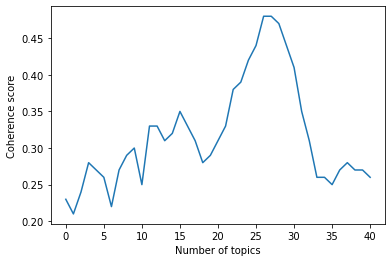

In [188]:
plt.plot(k_l)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.savefig('/Users/ilyamikheev/Downloads/coh_top.png', format='png', bbox_inches='tight', dpi=600)